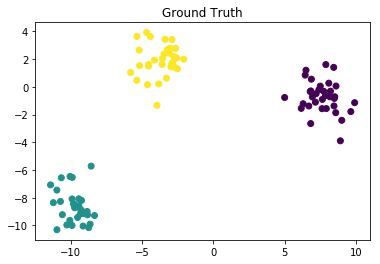

In [6]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

n_clusters = 3
n_samples = 100
np.random.seed(1234)

dataset_collection = []
dataset_collection.append(datasets.make_circles(n_samples, factor = 0.5, noise = 0.05))
dataset_collection.append(datasets.make_moons(n_samples, noise = 0.05))
dataset_collection.append(datasets.make_blobs(n_samples, centers = 3, n_features = 2))

dataset, clusters = dataset_collection[2]

def plot_results(X, clusters, title):
    plt.title(title)    
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.show()
    
plot_results(dataset, clusters, "Ground Truth")

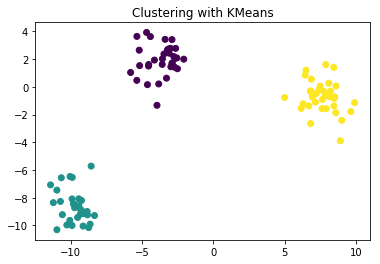

In [2]:
# try clustering with KMeans for comparision
km = KMeans(n_clusters)
km.fit(dataset)
y_pred = km.labels_

# plot results
plot_results(dataset, y_pred, "Clustering with KMeans")

In [4]:
from numpy.linalg import norm
from math import exp

# compute the affinity of samples X1, X2
def affinity_kernel(x1, x2):
    sigma_sq = .1
    return exp(-(norm(x1 - x2) ** 2) / (2 * sigma_sq))

# construct affinity matrix
A = np.zeros((len(dataset), len(dataset)))
for i in range(len(dataset) - 1):
    for j in range(i + 1, len(dataset)):
        A[i, j] = affinity_kernel(dataset[i], dataset[j])
        A[j, i] = A[i, j]

# print affinity matrix
np.set_printoptions(precision = 2)
print(A)

[[0.00e+00 0.00e+00 1.60e-05 ... 0.00e+00 1.16e-02 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 ... 4.64e-03 0.00e+00 6.49e-01]
 [1.60e-05 0.00e+00 0.00e+00 ... 0.00e+00 3.73e-04 0.00e+00]
 ...
 [0.00e+00 4.64e-03 0.00e+00 ... 0.00e+00 0.00e+00 3.23e-04]
 [1.16e-02 0.00e+00 3.73e-04 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 6.49e-01 0.00e+00 ... 3.23e-04 0.00e+00 0.00e+00]]


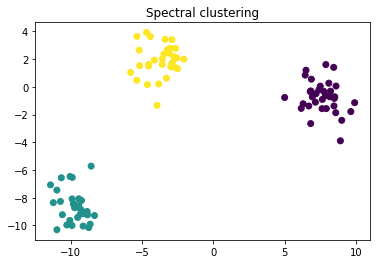

In [5]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def spectral_clustering(weighted_graph, cluster_count):
    W = weighted_graph
    K = cluster_count
    
    # Construct diagonal degree matrix
    D = np.zeros(A.shape)
    for i in range(A.shape[0]):
        D[i, i] = np.sum(A[i, :])
        
    # Construct Symmetric Laplacian Matrix:
    Dinvsq = np.sqrt(np.linalg.inv(D))
    I = np.matlib.identity(A.shape[0])
    L = I - Dinvsq @ A @ Dinvsq
    
    # Find the K first eigenvectors of L
    eigvals, eigvects = np.linalg.eigh(L)
    first_eigens = [i for i in range(K)]
    
    U = np.zeros((L.shape[0], K))
    U[:, :] = eigvects[:, first_eigens]
    
    # normalize new eigenvector-column-matrix
    T = (U.T / np.linalg.norm(U, axis = 1)).T
    
    # Finally, do clustering on reduced space using KMeans:
    km = KMeans(n_clusters = K, n_init = 20)
    km.fit(T)
    y_pred = km.labels_ #1 if x > 0 else 0 for x in T
    return y_pred

spectral_clusters = spectral_clustering(A, n_clusters)
plot_results(dataset, spectral_clusters, "Spectral clustering")